# EDA for energy anomaly detection data
Data sourced from Kaggle competition: https://www.kaggle.com/competitions/energy-anomaly-detection

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import svm, preprocessing
from sklearn.impute import SimpleImputer
from sklearn import metrics
from category_encoders.target_encoder import TargetEncoder

In [ ]:
df_train = pd.read_csv("../DATA/energy-anomaly-detection/train.csv")
df_weather = pd.read_csv("../DATA/energy-anomaly-detection/weather_train.csv")
df_building = pd.read_csv("../DATA/energy-anomaly-detection/building_metadata.csv")

In [30]:
print(df_building['primary_use'].unique())

<StringArray>
[                    'Education',           'Lodging/residential',
                        'Office', 'Entertainment/public assembly',
                         'Other',                        'Retail',
                       'Parking',               'Public services',
             'Warehouse/storage',        'Food sales and service',
             'Religious worship',                    'Healthcare',
                       'Utility',            'Technology/science',
      'Manufacturing/industrial',                      'Services']
Length: 16, dtype: str


## Stats

In [32]:
# This is more verbose and generally less common than merge
df_all = df_train.set_index(['building_id']).join(
    df_building.set_index(['building_id']), 
    how='left'
).reset_index()

df_all = df_all.set_index(['site_id', 'timestamp']).join(
    df_weather.set_index(['site_id', 'timestamp']), 
    how='left'
).reset_index()

te = TargetEncoder()
df_all['primary_use_enc'] = te.fit_transform(df_all['primary_use'], df_all['anomaly'])


### Correlation

Site_id will be retained, but floor_count will be dropped as they are highly correlated, but a lot of data is missing for the latter.
Site_id will be dropped and just building_id will be retained, just to help the model udnerstand the context of the buildings.
Primary use will be dropped as anomalies are equally distributed accross all categories.

In [ ]:
# Calculate the full correlation matrix
pearson_corr = df_all.select_dtypes(include=['int64', 'float64']).corr(method='spearman')

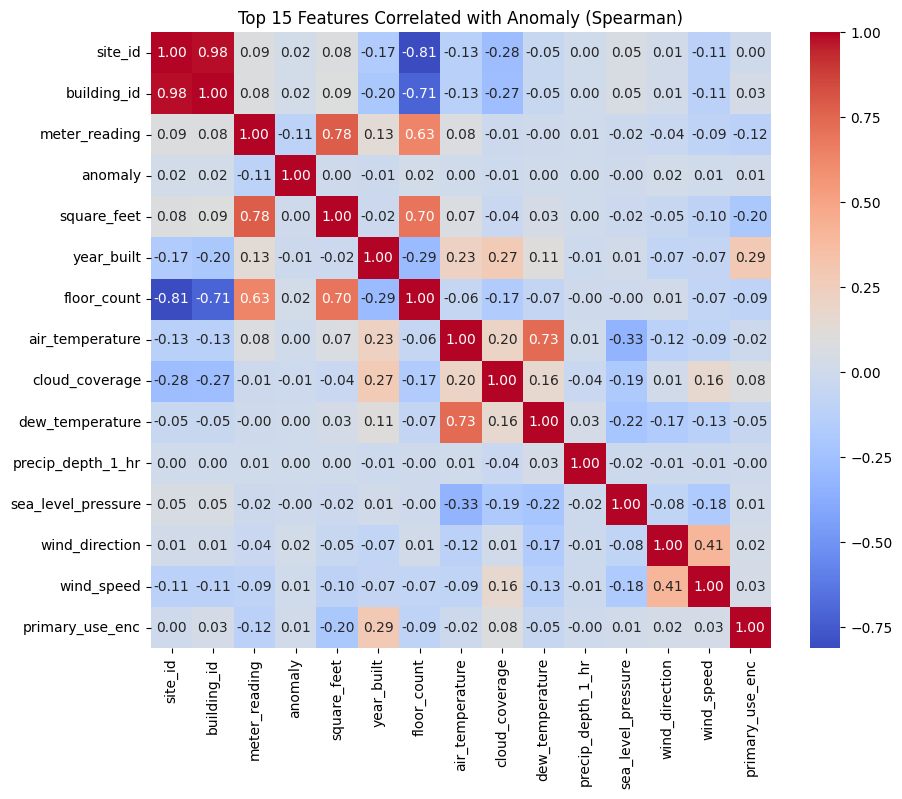

In [34]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Top 15 Features Correlated with Anomaly (Spearman)")
plt.show()

In [35]:
# See the actual percentages
analysis = df_all.groupby('primary_use')['anomaly'].mean().sort_values(ascending=False)
print(analysis)

primary_use
Other                            0.036973
Office                           0.022721
Lodging/residential              0.022683
Entertainment/public assembly    0.021468
Public services                  0.021347
Religious worship                0.020613
Education                        0.020507
Food sales and service           0.019809
Healthcare                       0.018580
Parking                          0.018272
Manufacturing/industrial         0.017133
Services                         0.011822
Name: anomaly, dtype: float64


In [42]:
# See the actual percentages
analysis = df_all.groupby('dew_temperature')['anomaly'].mean().sort_values(ascending=False)
print(analysis)

dew_temperature
 22.9    1.000000
 22.1    1.000000
 21.5    0.666667
 21.4    0.500000
 21.9    0.333333
           ...   
 19.3    0.000000
 19.2    0.000000
 19.1    0.000000
-32.7    0.000000
-32.9    0.000000
Name: anomaly, Length: 522, dtype: float64


### Perason correlation

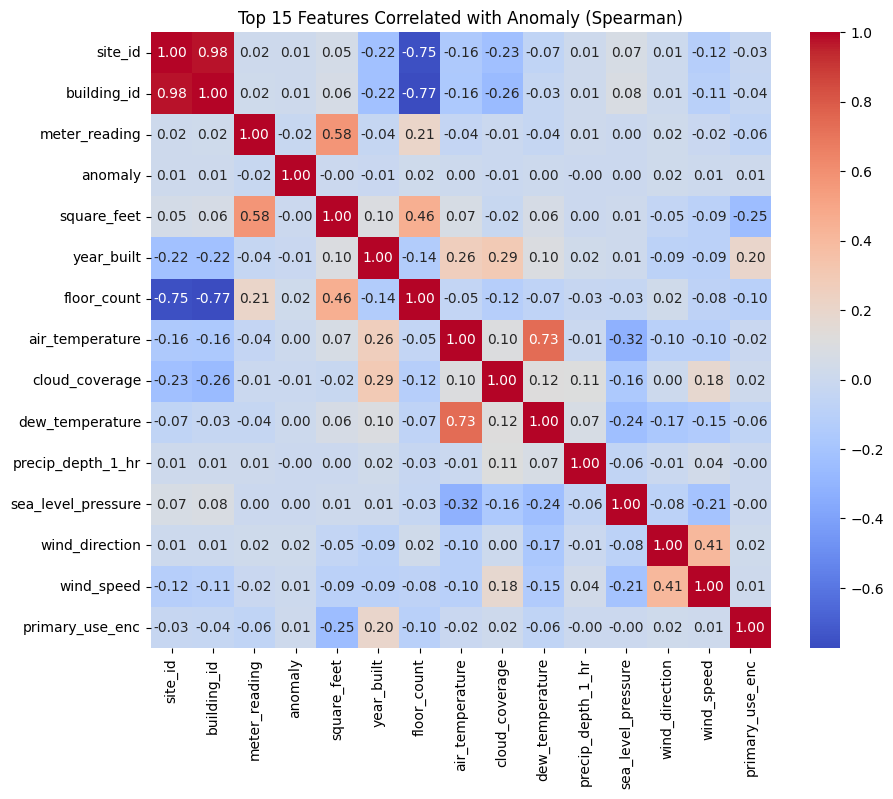

In [39]:
pearson_corr = df_all.select_dtypes(include=['int64', 'float64']).corr(method='pearson')
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Top 15 Features Correlated with Anomaly (Spearman)")
plt.show()

### Chi-square test (independence)

In [43]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

def calculate_cramers_v(contingency_table):
    """Calculates the Cramér's V statistic for categorical association."""
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    # Handle the division by zero if a table has only 1 row/column
    if min(k - 1, r - 1) == 0:
        return 0
    return np.sqrt(phi2 / min(k - 1, r - 1))

# 1. Identify categorical columns (strings or low-cardinality numbers like site_id)
# We exclude 'anomaly' (target) and 'timestamp' (too many values)
cat_cols = df_all.select_dtypes(include=['object', 'category']).columns.tolist()
if 'site_id' not in cat_cols: cat_cols.append('site_id') 

results = []

for col in cat_cols:
    if col == 'anomaly': continue
    
    # 2. Create the contingency table
    contingency_table = pd.crosstab(df_all[col], df_all['anomaly'])
    
    # 3. Run Chi-Square and get Cramér's V
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    v_score = calculate_cramers_v(contingency_table)
    
    results.append({
        'Feature': col,
        'Chi2 Statistic': round(chi2, 2),
        'P-Value': p,
        'Cramers V': round(v_score, 4),
        'Cardinality': df_all[col].nunique()
    })

# 4. Create the final summary table
chi_summary = pd.DataFrame(results).sort_values(by='Cramers V', ascending=False)
display(chi_summary)

C:\Users\ferna\AppData\Local\Temp\ipykernel_23976\2640495651.py:18: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_cols = df_all.select_dtypes(include=['object', 'category']).columns.tolist()


,Feature,Chi2 Statistic,P-Value,Cramers V,Cardinality
0,timestamp,131642.32,0.000000e+00,0.2743,8784
2,site_id,2688.44,0.000000e+00,0.0392,14
1,primary_use,338.54,6.431945e-66,0.0139,12
